In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
from pymc3 import Continuous
from theano import tensor 
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import threading
from multiprocessing.pool import ThreadPool
#exp, log, sqrt

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 24

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, gamma, trise, tfall):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))

In [3]:
def from_posterior(param, samples):
    smins = []
    smaxs = []
    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))
    
    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x = np.linspace(smin, smax, 1000)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    return Interpolated(param, x, y)

In [4]:
def make_curve(param, samples):
    smins = []
    smaxs = []

    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))

    

    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x, step = np.linspace(smin, smax, 1000, retstep = True)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    y = y + np.exp(-100)
    y_norm = y / (np.sum(y)*step)
    return param, x, y_norm
def make_prior(posterior_param):
    return Interpolated(posterior_param[0],posterior_param[1],posterior_param[2])

In [5]:
def model_run(model,i,trace, iterations, core):
    with model:
        # 10000 posterior samples
        trace[i] = pm.sample(iterations, cores = core)

In [6]:
#These are the values we are going to use for a test
np.random.seed(300)
filter_number = 3
trise_A = np.random.normal(2,.2, filter_number)
tfall_A = np.random.normal(20,2, filter_number)
Amplitude_A = np.random.normal(1500,150, filter_number)
Beta_A =  np.random.normal(-5,.5, filter_number)
t0_A =  np.random.normal(60,1, filter_number)
gamma_A = np.random.normal(60,1, filter_number)
end_A = 300
observations_before = [5, 25, 15] #data set size double for total observations
observations_after = [30, 5, 20]
sigma_A = 100 #Telescope error

In [7]:
time_axis_filters = []
Y_actual_filter = []
Y_observed_filter = []

In [8]:
for i in range(filter_number):
    size1 = observations_before[i]
    size2 = observations_after[i]
    time_axis_rise = np.random.uniform(low=0, high=(gamma_A[i]+t0_A[i]), size=size1)
    time_axis_rise = np.sort(time_axis_rise)
    time_axis_fall = np.random.uniform(low=(gamma_A[i]+t0_A[i]), high=end_A, size=size2)
    time_axis_fall = np.sort(time_axis_fall)
    Y_actual_rise = SuperNova_CurveRise(time_axis_rise, Amplitude_A[i], Beta_A[i], t0_A[i], trise_A[i])
    Y_actual_fall = SuperNova_CurveFall(time_axis_fall, Amplitude_A[i], Beta_A[i], t0_A[i], gamma_A[i], trise_A[i], tfall_A[i])
    time_axis_filters.append(np.append(time_axis_rise, time_axis_fall))
    Y_actual_filter.append(np.append(Y_actual_rise, Y_actual_fall))
    Y_observed_filter.append(Y_actual_filter[i] + np.random.normal(0,sigma_A, len(Y_actual_filter[i])))

Text(0.5, 1.0, 'Actual Light Curve')

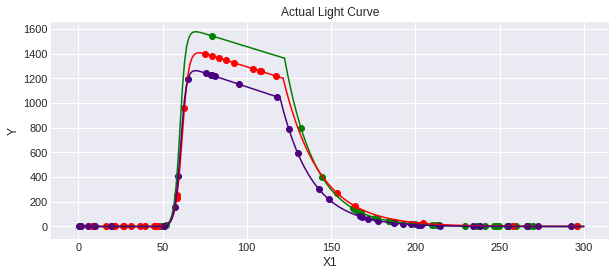

In [9]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
colours = ["green", "red", "indigo"]
for i in range(filter_number):
    axes.scatter(time_axis_filters[i], Y_actual_filter[i], color = colours[i])

for i in range(filter_number):
    big_time_axis_rise = np.linspace(0,t0_A[i]+gamma_A[i],num = 100)
    axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A[i], Beta_A[i], t0_A[i], trise_A[i]), color = colours[i])

for i in range(filter_number):
    big_time_axis_fall = np.linspace(t0_A[i]+gamma_A[i],end_A,num = 100)
    axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A[i], Beta_A[i], t0_A[i], gamma_A[i], trise_A[i], tfall_A[i]), color = colours[i])

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Actual Light Curve")

Text(0.5, 1.0, 'Observed Light Curve')

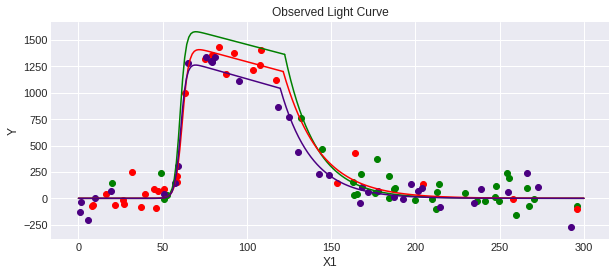

In [10]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
colours = ["green", "red", "indigo"]
for i in range(filter_number):
    axes.scatter(time_axis_filters[i], Y_observed_filter[i], color = colours[i])

for i in range(filter_number):
    big_time_axis_rise = np.linspace(0,t0_A[i]+gamma_A[i],num = 100)
    axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A[i], Beta_A[i], t0_A[i], trise_A[i]), color = colours[i])

for i in range(filter_number):
    big_time_axis_fall = np.linspace(t0_A[i]+gamma_A[i],end_A,num = 100)
    axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A[i], Beta_A[i], t0_A[i], gamma_A[i], trise_A[i], tfall_A[i]), color = colours[i])


axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

In [11]:
model_filters = []
for i in range(filter_number):
    model_filters.append(pm.Model())

In [12]:
for i in range(filter_number):
    with model_filters[i]:

        # Priors for unknown model parameters

        trise = pm.Uniform('trise', lower = 0.01, upper = 50)
        tfall = pm.Uniform('tfall', lower = 1, upper = 300)
        Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
        Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
        Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i])/150, upper = 0)
        t0 = pm.Uniform('t0', lower = np.min(time_axis_filters[i]), upper = np.max(time_axis_filters[i]))
        sigma = pm.HalfNormal('sigma', sigma=sigma_A)

        #gamma = pm.Uniform('gamma', lower = np.min(time_axis), upper = np.max(time_axis), testval = (least_slope[0]-))
        no_p = pm.Normal.dist(mu = 5, sigma = 5)
        yes_p = pm.Normal.dist(mu = 60, sigma = 30)

        gamma = pm.Mixture("gamma", w=[2/3,1/3], comp_dists = [no_p, yes_p])
        #gamma = pm.math.sum(pm.Normal("no_p", mu = 5, sigma = 5),pm.Normal("yes_p", mu = 60, sigma = 30))

        # Expected value of outcome
        mu_rise = SuperNova_CurveRise(time_axis_filters[i], Amplitude, Beta, t0, trise)
        mu_fall = SuperNova_CurveFall(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall)

        mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])
    
    

In [13]:
map_estimate = []
for basic_model in model_filters:
    map_estimate.append(pm.find_MAP(model=basic_model))

logp = -250, ||grad|| = 88.75: 100%|██████████| 148/148 [00:00<00:00, 1823.08it/s]     
logp = -214.67, ||grad|| = 0.45861: 100%|██████████| 139/139 [00:00<00:00, 1757.32it/s] 
logp = -244.09, ||grad|| = 4.8901: 100%|██████████| 98/98 [00:00<00:00, 1800.52it/s]    


In [14]:
trace = []
for basic_model in model_filters:
    with basic_model:
        # 10000 posterior samples
        iterations = int(100000/core_count)
        trace.append(pm.sample(iterations, cores = core_count))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (24 chains in 24 jobs)
NUTS: [gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 24 chains, 521 divergences: 100%|██████████| 111984/111984 [01:23<00:00, 1345.95draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `tar

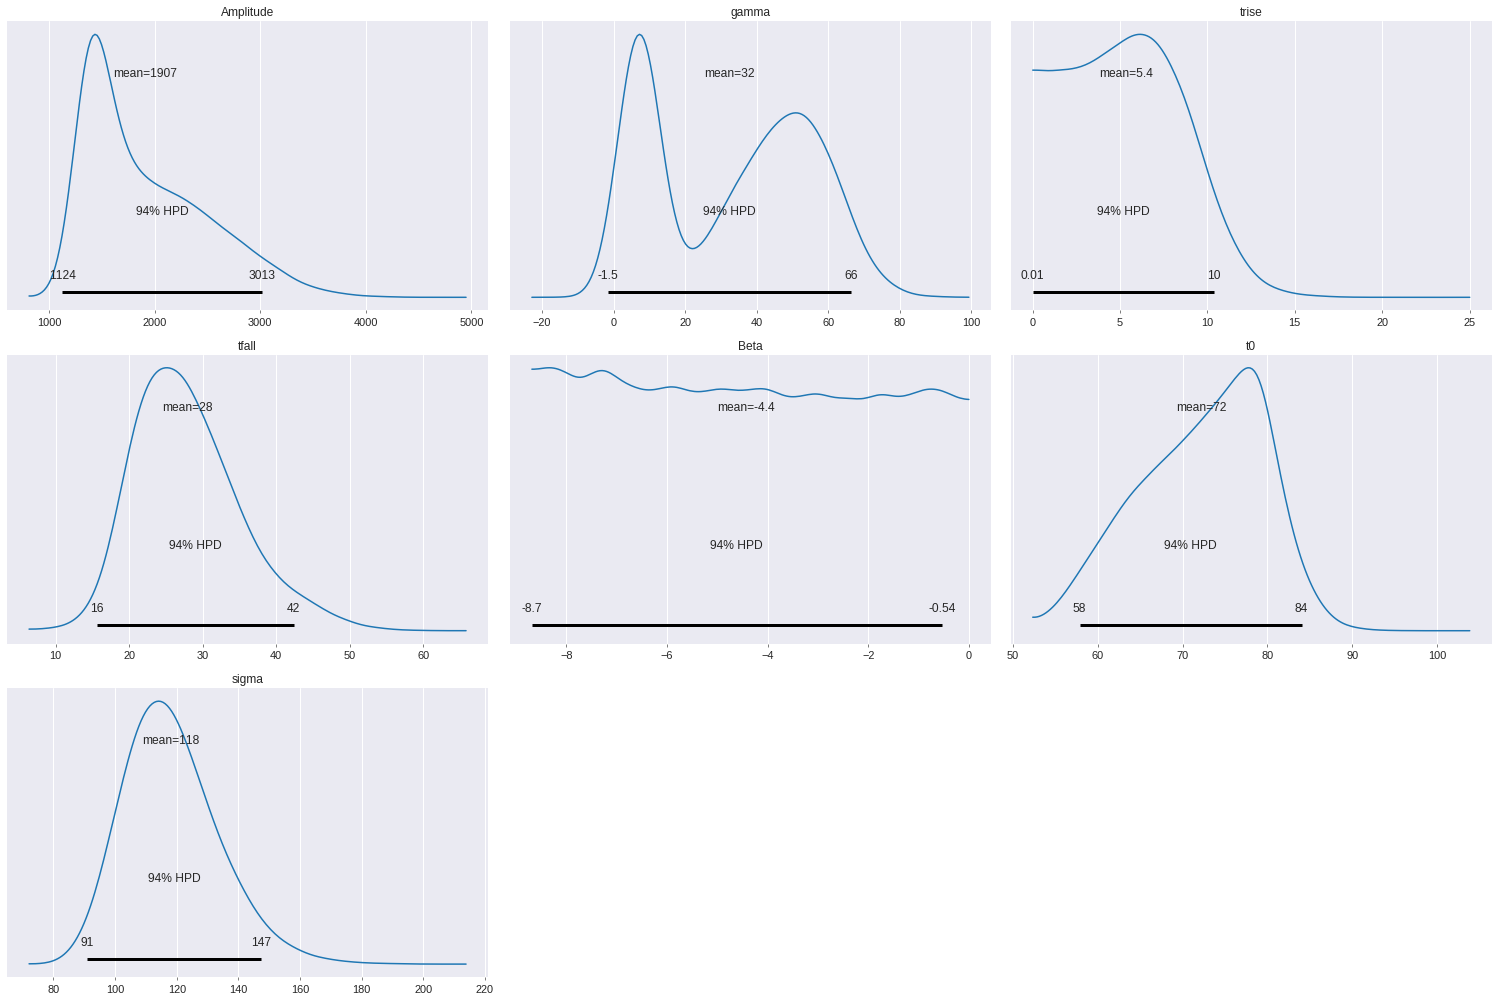

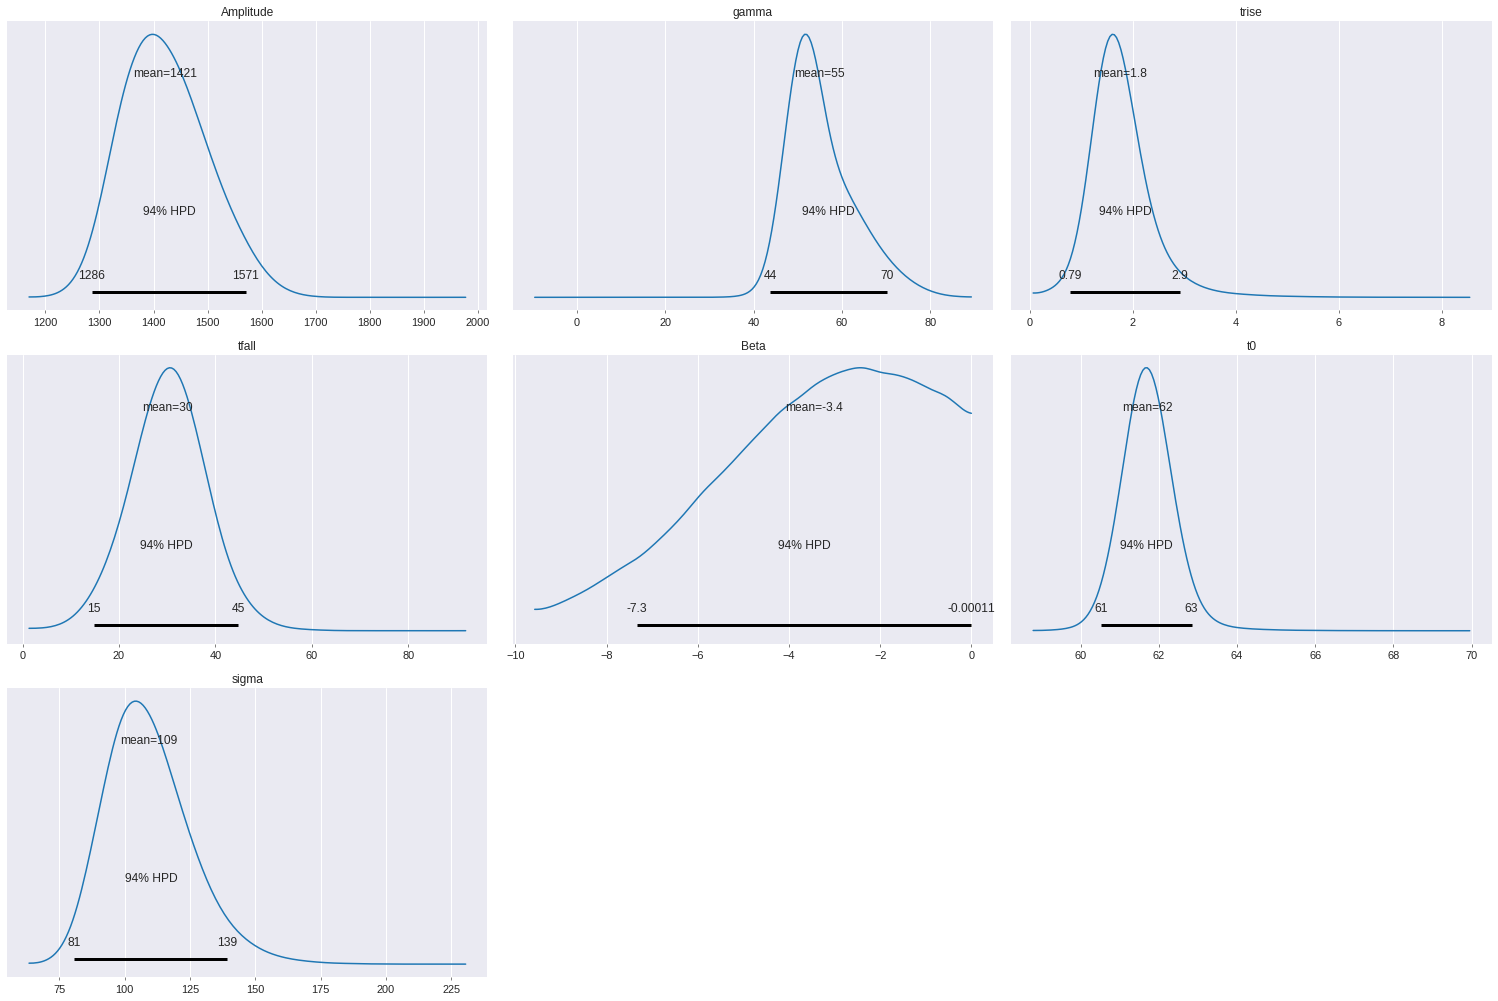

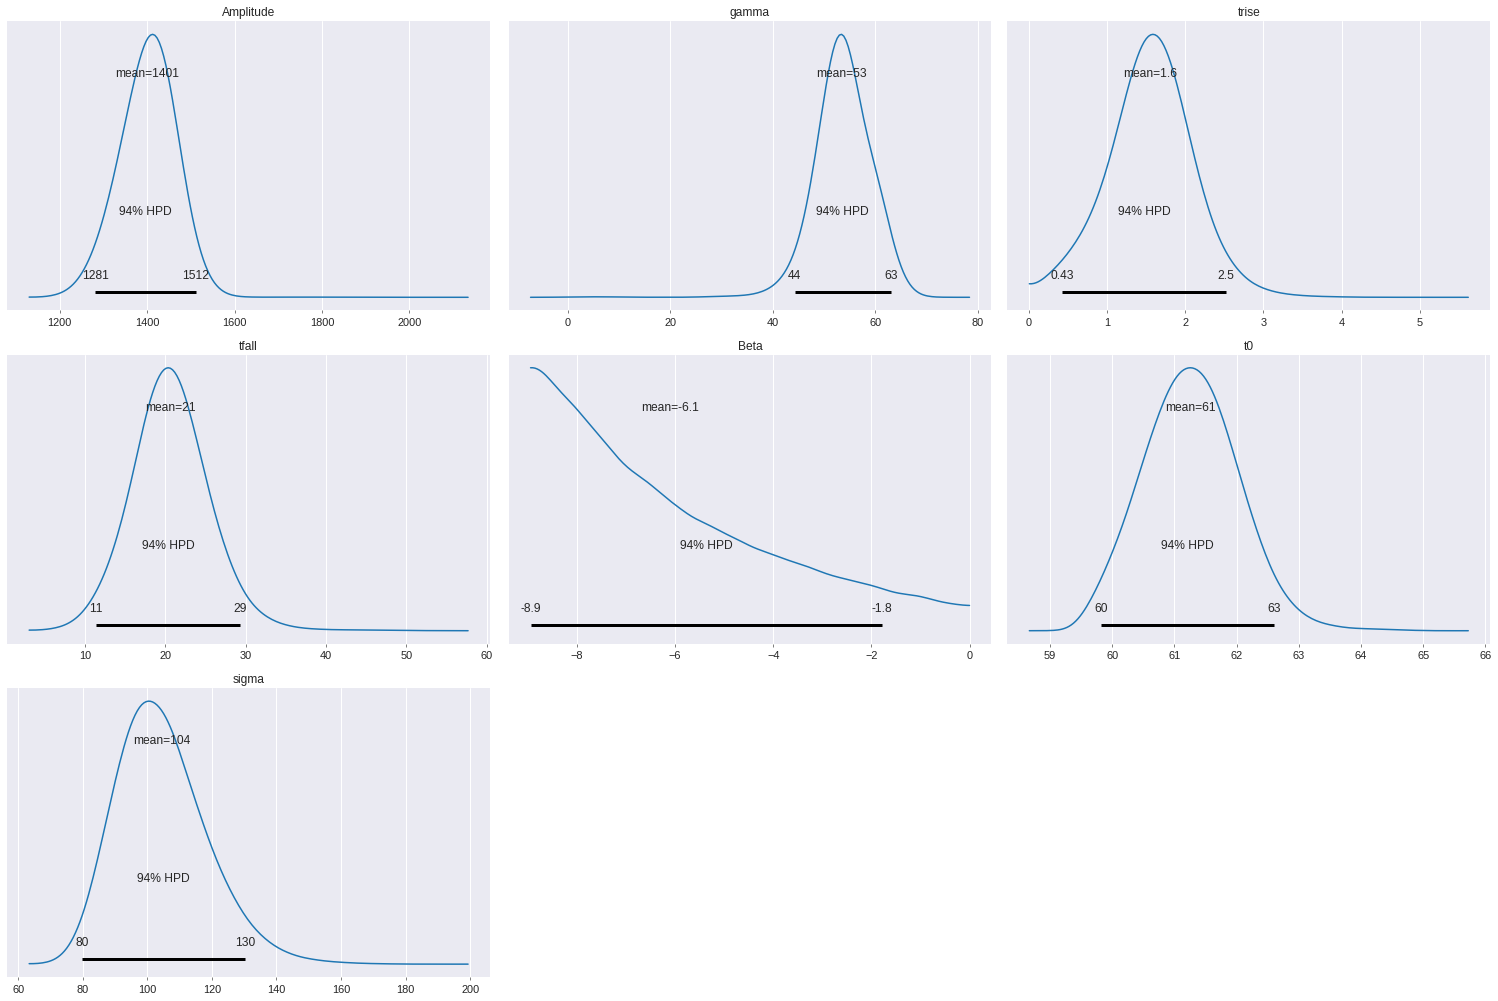

In [15]:
for posterior in trace:
    pm.plot_posterior(posterior)

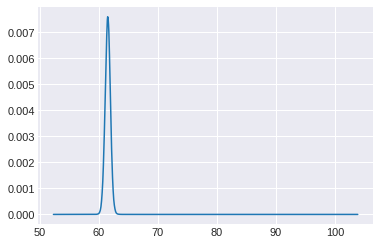

In [16]:
smin1, smax1 = np.min(trace[0]["t0"]), np.max(trace[0]["t0"])
smin2, smax2 = np.min(trace[1]["t0"]), np.max(trace[1]["t0"])
smin3, smax3 = np.min(trace[2]["t0"]), np.max(trace[2]["t0"])
smin = np.min([smin1,smin2,smin3])
smax = np.max([smax1,smax2,smax3])
width = smax - smin

x = np.linspace(smin, smax, 1000)
y1 = stats.gaussian_kde(trace[0]["t0"])(x)
y2 = stats.gaussian_kde(trace[1]["t0"])(x)
y3 = stats.gaussian_kde(trace[2]["t0"])(x)
#plt.plot(x, y1)
#plt.plot(x, y2)
#plt.plot(x, y3)
plt.plot(x, y1*y2*y3)

In [17]:
combined_model = []
for i in range(filter_number):
    combined_model.append(pm.Model())

In [18]:
#time_axis = np.hstack(time_axis_filters)
#Y_observed = np.hstack(Y_observed_filter)
#Y_actual = np.hstack(Y_actual_filter)
'''
trise = from_posterior("trise", trace)

tfall = from_posterior("tfall", trace)

Amplitude = from_posterior("Amplitude", trace)

Beta = from_posterior("Beta", trace)

t0 = from_posterior("t0", trace)

sigma = from_posterior("sigma", trace)

gamma = from_posterior("gamma", trace)
'''

'\ntrise = from_posterior("trise", trace)\n\ntfall = from_posterior("tfall", trace)\n\nAmplitude = from_posterior("Amplitude", trace)\n\nBeta = from_posterior("Beta", trace)\n\nt0 = from_posterior("t0", trace)\n\nsigma = from_posterior("sigma", trace)\n\ngamma = from_posterior("gamma", trace)\n'

In [19]:
name, x, y = make_curve("t0", trace)

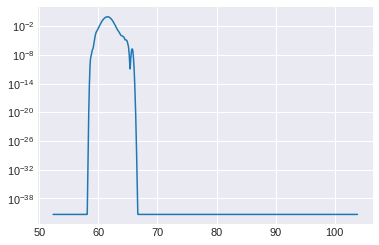

In [20]:
plt.plot(x,y)
plt.yscale("log")

In [21]:
trise_posterior = make_curve("trise", trace)

tfall_posterior = make_curve("tfall", trace)

Amplitude_posterior = make_curve("Amplitude", trace)

Beta_posterior = make_curve("Beta", trace)

t0_posterior = make_curve("t0", trace)

sigma_posterior = make_curve("sigma", trace)

gamma_posterior = make_curve("gamma", trace)

In [22]:
for i in range(filter_number):
    with combined_model[i]:
        trise = make_prior(trise_posterior)

        tfall = make_prior(tfall_posterior)

        Amplitude = make_prior(Amplitude_posterior)

        Beta = make_prior(Beta_posterior)

        t0 = make_prior(t0_posterior)

        sigma = make_prior(sigma_posterior)

        gamma = make_prior(gamma_posterior)

        # Expected value of outcome
        mu_rise = SuperNova_CurveRise(time_axis_filters[i], Amplitude, Beta, t0, trise)
        mu_fall = SuperNova_CurveFall(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall)

        mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])

In [23]:
combined_map_estimate = []
for i in combined_model:
    combined_map_estimate.append(pm.find_MAP(model=i))

logp = -228.68, ||grad|| = 1.3702: 100%|██████████| 63/63 [00:00<00:00, 1073.58it/s]   
logp = -193.76, ||grad|| = 0.84239: 100%|██████████| 53/53 [00:00<00:00, 1050.52it/s]  
logp = -222.9, ||grad|| = 1.9971: 100%|██████████| 51/51 [00:00<00:00, 1080.50it/s]   


In [24]:
trace_all = []
for basic_model in combined_model:
    with basic_model:
        # 10000 posterior samples
        iterations = int(100000/core_count)
        trace_all.append(pm.sample(iterations, cores = core_count))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (24 chains in 24 jobs)
NUTS: [gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 24 chains, 0 divergences: 100%|██████████| 111984/111984 [01:01<00:00, 1823.29draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (24 chains in 24 jobs)
NUTS: [gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 24 chains, 0 divergences: 100%|██████████| 111984/111984 [01:01<00:00, 1835.65draws/s]
The acceptance probability does not match the target. It is 0.9113378778634819, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (24 chains in

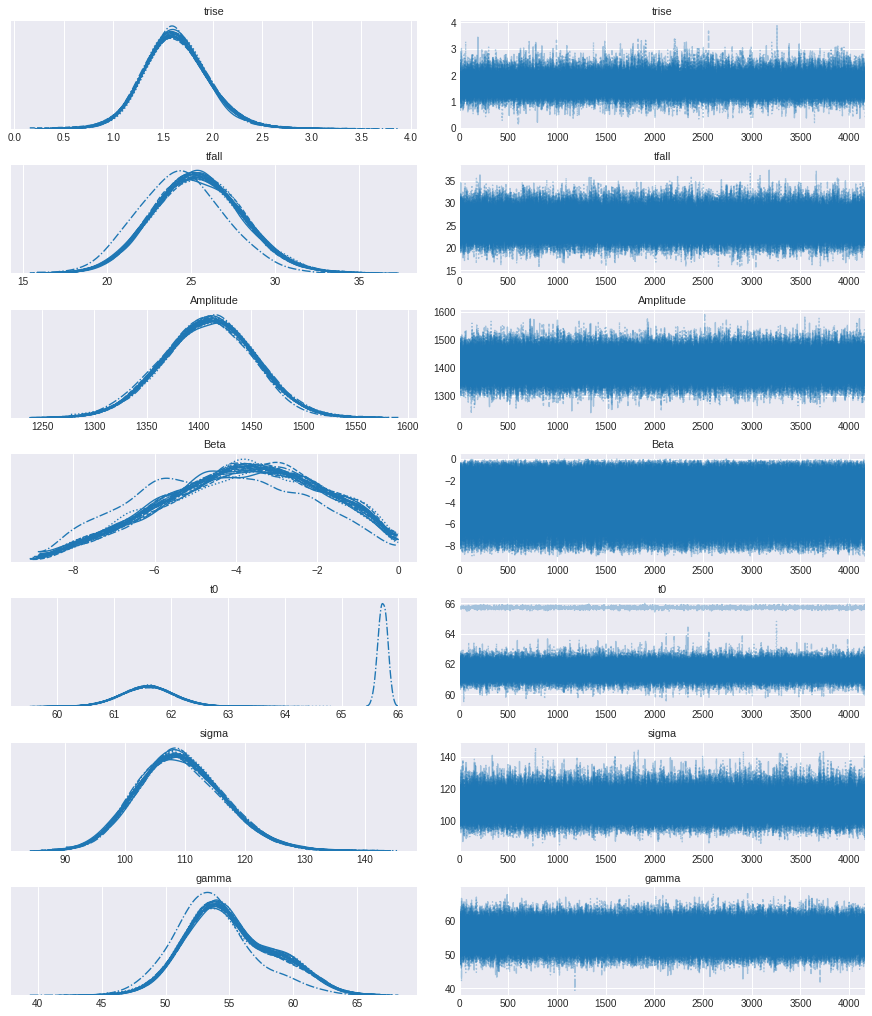

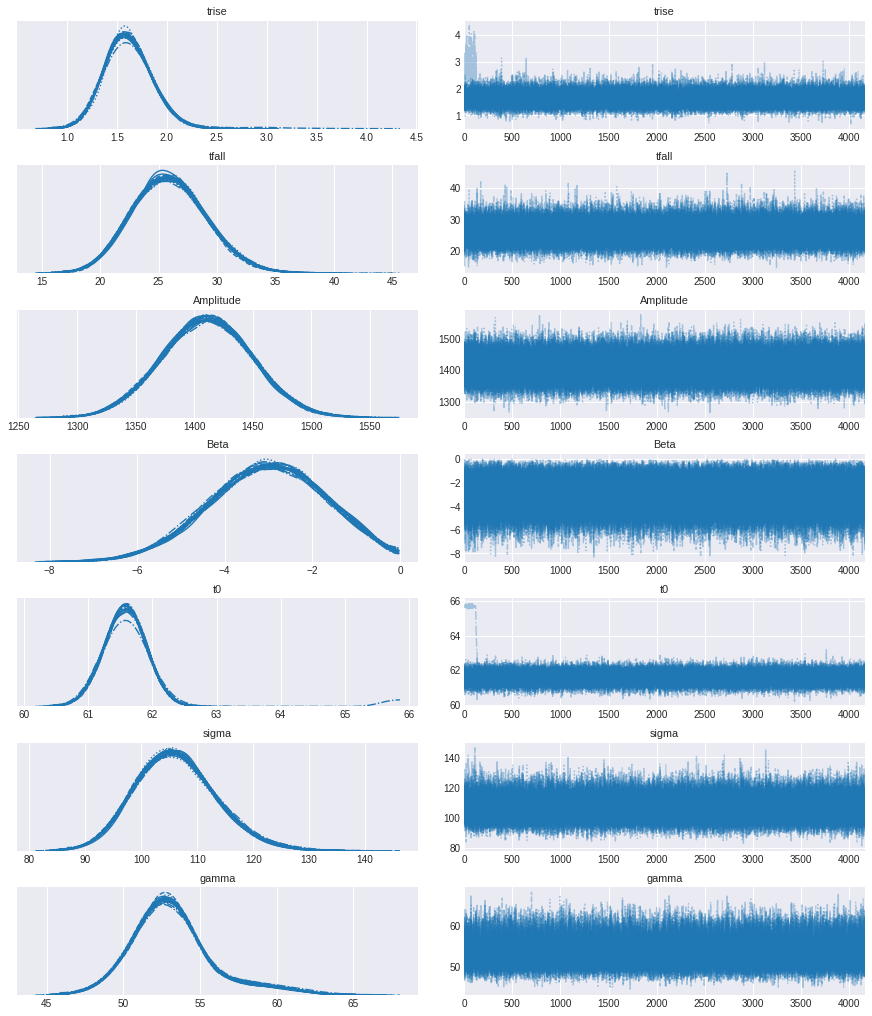

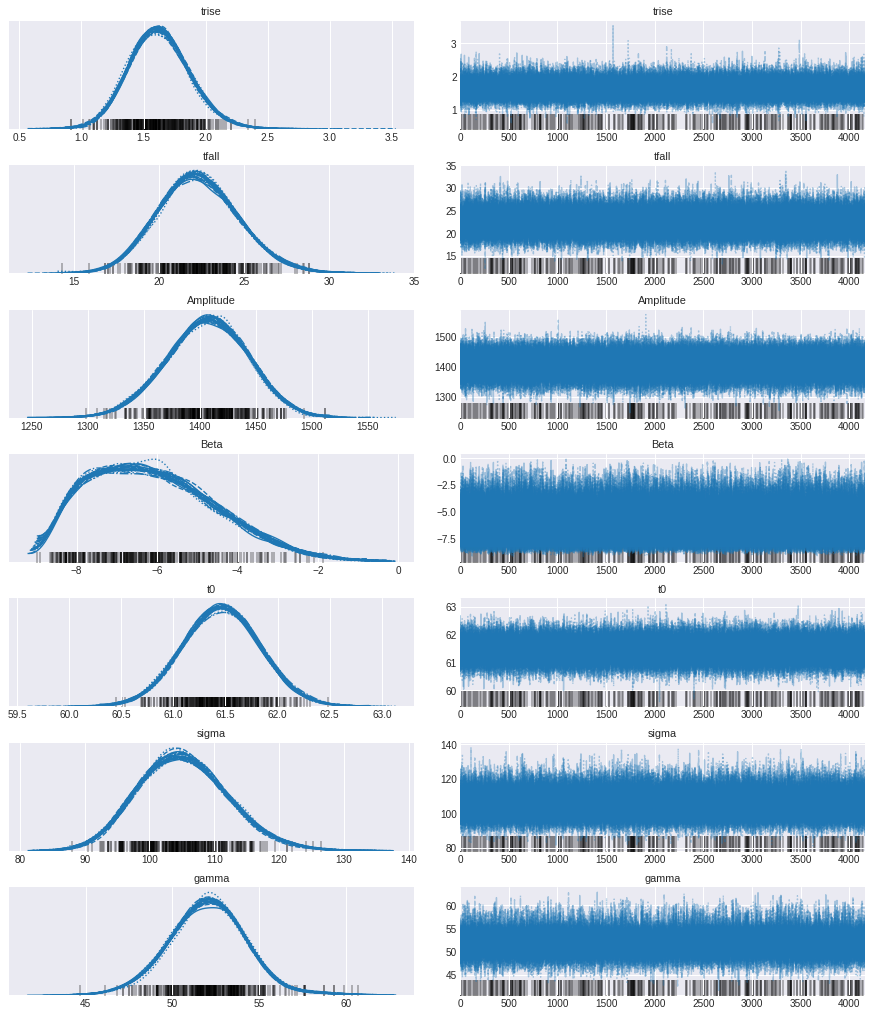

In [25]:
for i in trace_all:
    pm.traceplot(i)

In [26]:
summary_tables = []
for i in trace_all:
    summary_tables.append(pm.summary(i))

In [27]:
trise_R = []
tfall_R = []
Amplitude_R = []
Beta_R = []
t0_R = []
gamma_R = []
for i in summary_tables:
    trise_R.append(i["mean"]["trise"])
    tfall_R.append(i["mean"]["tfall"])
    Amplitude_R.append(i["mean"]["Amplitude"])
    Beta_R.append(i["mean"]["Beta"])
    t0_R.append(i["mean"]["t0"])
    gamma_R.append(i["mean"]["gamma"])

In [28]:
print(trise_R, trise_A)
print(tfall_R, tfall_A)
print(Amplitude_R, Amplitude_A)
print(Beta_R, Beta_A)
print(t0_R, t0_A)
print(gamma_R, gamma_A)

[1.628, 1.612, 1.623] [1.70296593 1.94795905 1.71508693]
[25.338, 25.903, 22.3] [18.21720214 21.52232671 18.60248548]
[1409.257, 1410.698, 1406.045] [1624.43774639 1460.31621631 1310.39968104]
[-3.863, -3.033, -6.093] [-4.20579488 -4.32709029 -4.5397187 ]
[61.754, 61.576, 61.455] [60.39000598 61.6591469  60.70539097]
[54.945, 53.197, 52.003] [61.98868807 59.84796808 59.03996498]


Text(0, 0.5, 'y_observed')

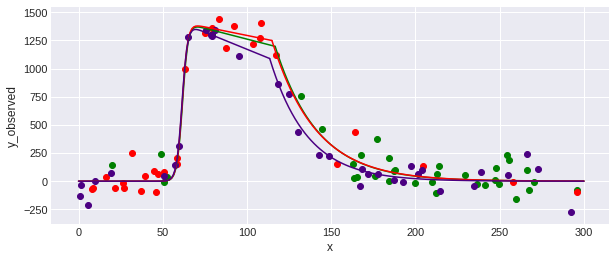

In [29]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))
colours = ["green", "red", "indigo"]

for i in range(filter_number):
    big_time_axis_rise = np.linspace(0,t0_R[i]+gamma_R[i],num = 100)
    ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R[i], Beta_R[i], t0_R[i], trise_R[i]), color = colours[i])

for i in range(filter_number):
    big_time_axis_fall = np.linspace(t0_R[i]+gamma_R[i],end_A,num = 100)
    ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R[i], Beta_R[i], t0_R[i], gamma_R[i], trise_R[i], tfall_R[i]), color = colours[i])

for i in range(filter_number):
    ax.scatter(time_axis_filters[i], Y_observed_filter[i], color = colours[i])
    
ax.set_xlabel('x')
ax.set_ylabel('y_observed')

Text(0, 0.5, 'y_actual')

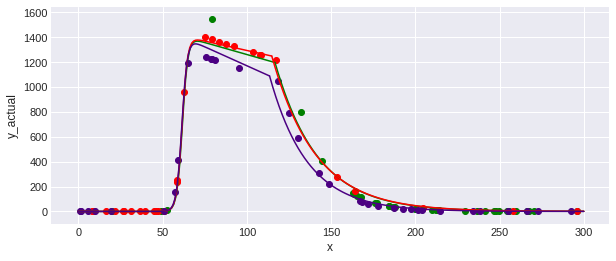

In [30]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))
colours = ["green", "red", "indigo"]

for i in range(filter_number):
    big_time_axis_rise = np.linspace(0,t0_R[i]+gamma_R[i],num = 100)
    ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R[i], Beta_R[i], t0_R[i], trise_R[i]), color = colours[i])

for i in range(filter_number):
    big_time_axis_fall = np.linspace(t0_R[i]+gamma_R[i],end_A,num = 100)
    ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R[i], Beta_R[i], t0_R[i], gamma_R[i], trise_R[i], tfall_R[i]), color = colours[i])

for i in range(filter_number):
    ax.scatter(time_axis_filters[i], Y_actual_filter[i], color = colours[i])
ax.set_xlabel('x')
ax.set_ylabel('y_actual')